This is a notebook that analyzes the files created to describe the dataset before the quality control step.

The files were created using commands:

1. Data description -> General distribution of depth, missingness, heterozygosity (.vchk file output)
bcftools stats joint.hg38.vcf.gz > joint.hg38.vchk

2. Generate a summary of the number of SNPs and Ts/Tv ratio for each FILTER category. (.FILTER.summary file output)
vcftools --gzvcf joint.hg38.vcf.gz --FILTER-summary --out joint.hg38.PRE-QC
 
3. Site missingness -> Generate a file reporting the missingness on a per-site basis. (.lmiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-site --out joint.hg38.PRE-QC

4. Individual missingness -> Generate a file reporting the missingness on a per-individual basis.(.imiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-indv --out joint.hg38.PRE-QC

5. Site depth -> Generate a file containing the mean depth per site across all individuals. (ldepth.mean file output)
vcftools --gzvcf joint.hg38.vcf.gz --site-mean-depth --out joint.hg38.PRE-QC 

6. Individual depth -> Generate a file containing the mean depth per individual. (.idepth file output)
vcftools --gzvcf joint.hg38.vcf.gz --depth --out joint.hg38.PRE-QC

7. Individual heterozygosity (.het file output)
vcftools --gzvcf joint.hg38.vcf.gz --het --out joint.hg38.PRE-QC

bcftools version: 1.9-94-g9589876
vcftools version: 0.1.15

Short summary of what we expect to learn from each file

1. vchk : stats by non-reference allele frequency, depth distribution, stats by quality and per-sample counts, singleton stats, etc. are included in this file

2. FILTER.summary : Generates a summary of the number of SNPs and Ts/Tv ratio for each FILTER category

3. lmiss : reports the missingness on a per-site basis

4. imiss : reports the missingness on a per-individual basis

5. ldepth.mean : contains the mean depth per site averaged across all individuals

6. idepth : contains the mean depth per individual

7. het : Calculates a measure of heterozygosity on a per-individual basis. Specfically, the inbreeding coefficient, F, is estimated for each individual using a method of moments

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Check the mean depth per chromosome using ldepth.mean file
# Does each chromosome have similar mean depth or is there a variation? 
# Are there regions in each chromosomes that have smaller mean depth than other?


notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.ldepth.mean")

# Read the mean depth file and divide the info into chromosomes.
per_chr_depth = {}
with open(depth_file_path, 'r') as f:
    f.readline()  # skip header
    for line in f:
        ch, depth = line.split('\t')[0][3:], float(line.split('\t')[2])
        if ch not in per_chr_depth.keys():
            print(ch)
            per_chr_depth[ch] = [depth]
        else:
            per_chr_depth[ch].append(depth)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


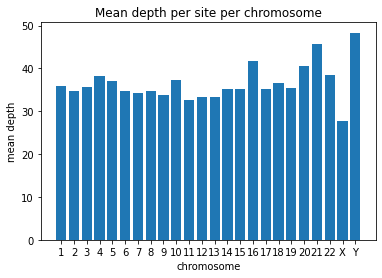

In [23]:
# Plot the mean depth of each chromosome 
plt.bar(list (per_chr_depth.keys()),[np.mean(per_chr_depth[i]) for i in per_chr_depth.keys()])
plt.title('Mean depth per site per chromosome')
plt.xlabel('chromosome')
plt.ylabel('mean depth')
plt.show()

In [14]:
# There's a lot of variation in the mean depth per site. What's the distribution of those mean depths per chromosome? 
# How much do they actually vary?

def make_cummulant(depths):

    # Show a cumulant graph for the distribution of mean depth values
    bins = np.arange(0, 101, 1)      # there are some big outliers but most of the distribution is around 0 - 70 mean depth
    depth_values, bins, _ = plt.hist(depths, bins=bins)


    # Calculate the cumulant for BLAST noref identities
    depth_total = float(sum(depth_values))

    depth_values_fractions = [0.0]
    current_total = 0.0
    for i in depth_values:
        current_total += (i/depth_total)
        depth_values_fractions.append(current_total)

    return(bins, depth_values_fractions)
    

In [24]:
def make_4_cummulant_graphs(chromosomes):
    """
    Given 4 chromosome labels, create a graph with 4 panels that show
    the distribution of the mean depth scores.
    """
    # Show a cumulant graph for the distribution of identity scores
    bins1, fractions1 = make_cummulant(per_chr_depth[chromosomes[0]])
    bins2, fractions2 = make_cummulant(per_chr_depth[chromosomes[1]])
    bins3, fractions3 = make_cummulant(per_chr_depth[chromosomes[2]])
    bins4, fractions4 = make_cummulant(per_chr_depth[chromosomes[3]])

    plt.clf()
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    ax1.plot(bins1, fractions1, label='chr '+chromosomes[0], color='blue')
    ax2.plot(bins2, fractions2, label='chr '+chromosomes[1], color='red')
    ax3.plot(bins3, fractions3, label='chr '+chromosomes[2], color='magenta')
    ax4.plot(bins4, fractions4, label='chr '+chromosomes[3], color='green')

    #plt.plot(bins, fractions)
    ax3.set_xlabel('mean depth')
    ax3.set_ylabel('fraction of sites')
    fig.legend()
    fig.suptitle('What is the distribution of mean depth values for different chromosomes?')
    plt.show()

<Figure size 432x288 with 0 Axes>

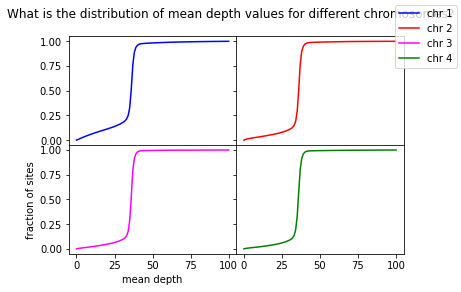

<Figure size 432x288 with 0 Axes>

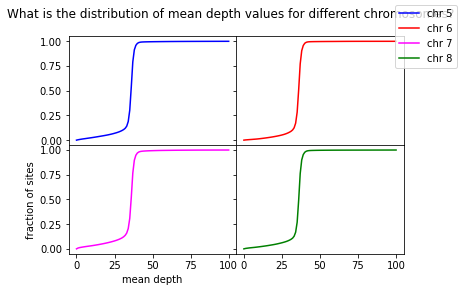

<Figure size 432x288 with 0 Axes>

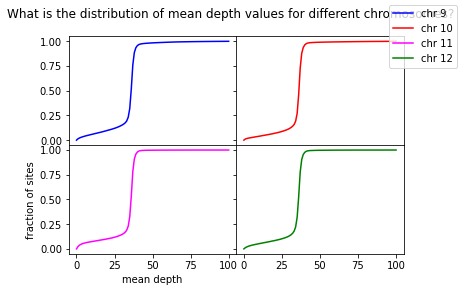

<Figure size 432x288 with 0 Axes>

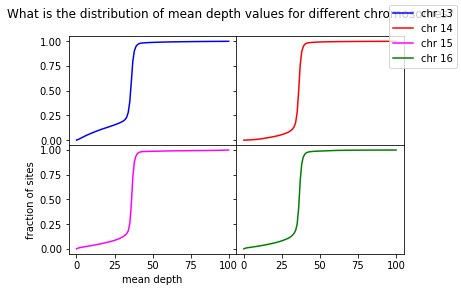

<Figure size 432x288 with 0 Axes>

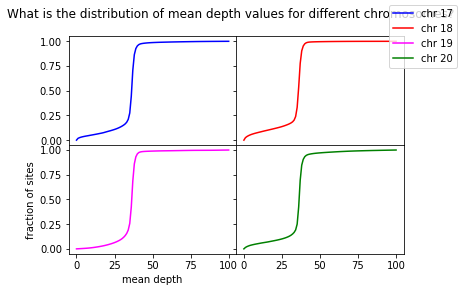

<Figure size 432x288 with 0 Axes>

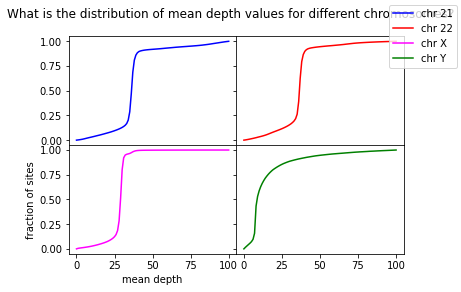

In [26]:
# Show a cumulant graph for the distribution of identity scores
make_4_cummulant_graphs(['1', '2', '3', '4'])
make_4_cummulant_graphs(['5', '6', '7', '8'])
make_4_cummulant_graphs(['9', '10', '11', '12'])
make_4_cummulant_graphs(['13', '14', '15', '16'])
make_4_cummulant_graphs(['17', '18', '19', '20'])
make_4_cummulant_graphs(['21', '22', 'X', 'Y'])

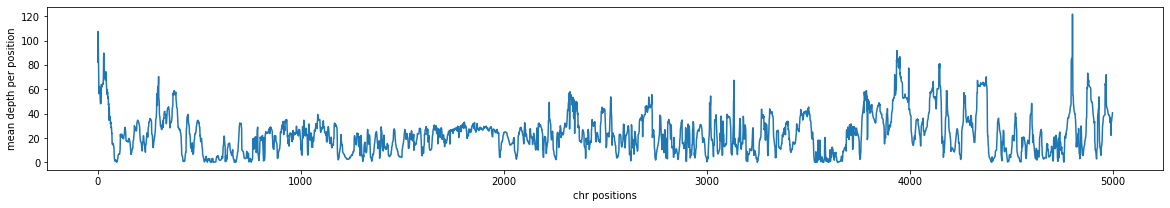

In [31]:
# What is the mean depth for the consecutive positions in the chromosome?

dist_range = [0,5000] # position range we want to plot (start, end)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(dist_range[0],dist_range[1]), per_chr_depth['1'][dist_range[0]:dist_range[1]])
plt.ylabel('mean depth per position')
plt.xlabel('chr positions')
plt.show()


In [39]:
# What is the number of bases that are covered above a particular depth? 

depths = [10, 15, 20, 25, 30, 35, 40]
chromosomes = list(per_chr_depth.keys())

# For each chromosome, calculate the number of sites that have a depth above the set threshold
# Calculate a percentage of sites per chromosome
sites_per_chr_per_depth = {}
for chr in chromosomes:
    chr_depths = np.array(per_chr_depth[chr])
    total = float(len(chr_depths))
    for d in depths:
        good_sites = sum(chr_depths >= d)
        if chr not in sites_per_chr_per_depth.keys():
            sites_per_chr_per_depth[chr] = {d: good_sites/total}
        else:
            sites_per_chr_per_depth[chr][d] = good_sites/total
            

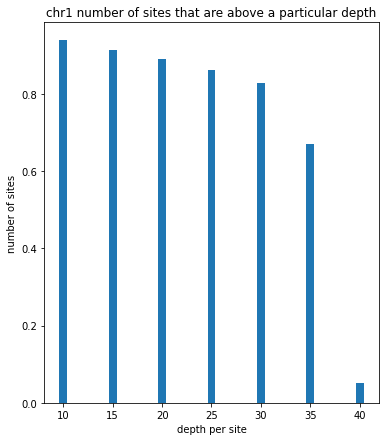

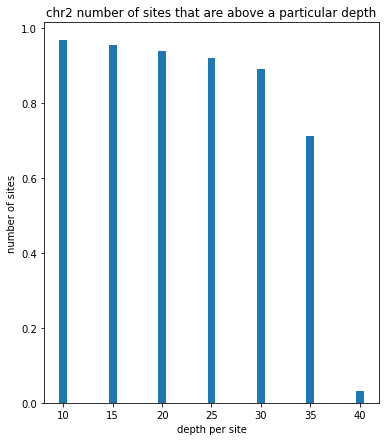

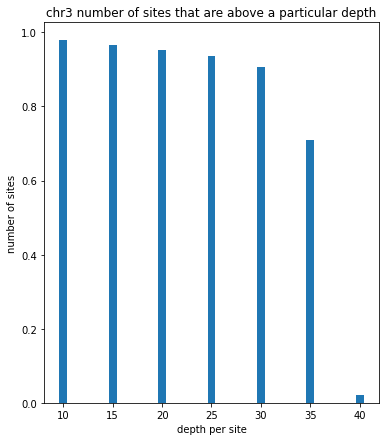

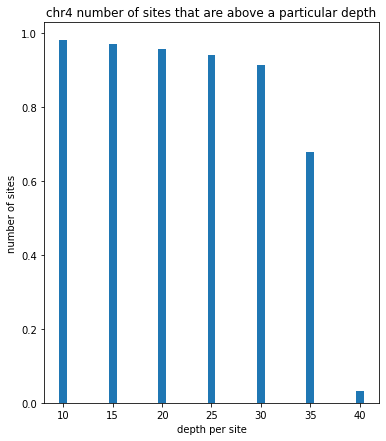

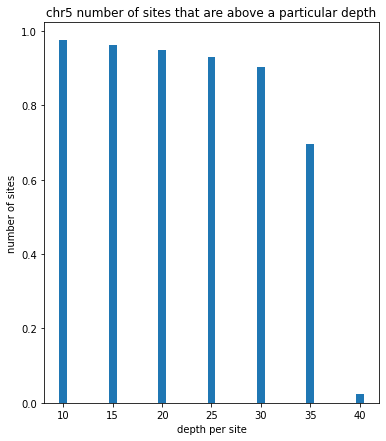

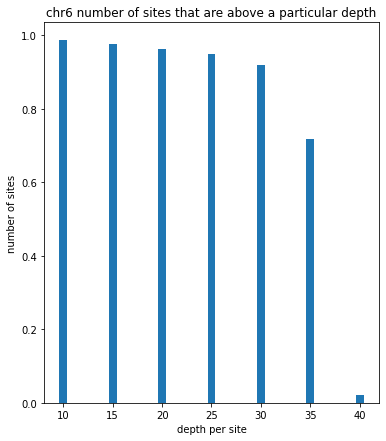

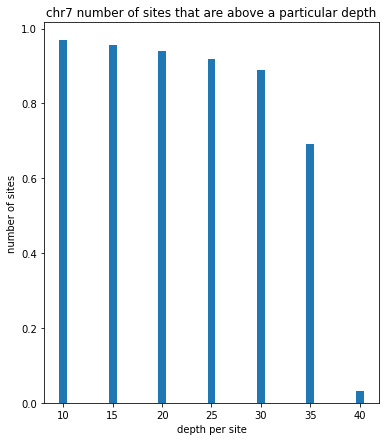

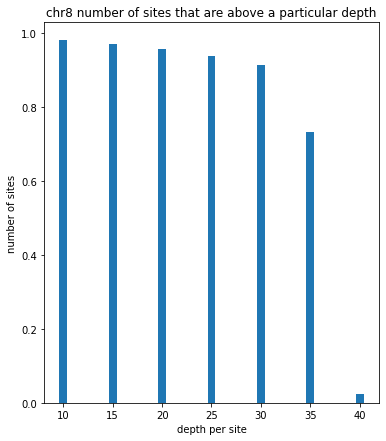

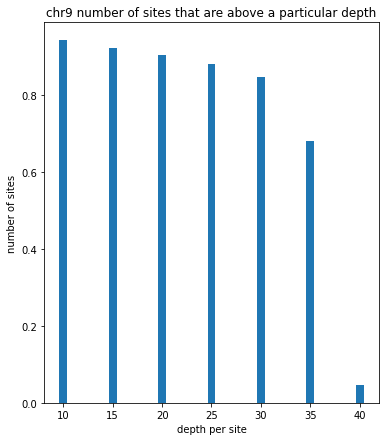

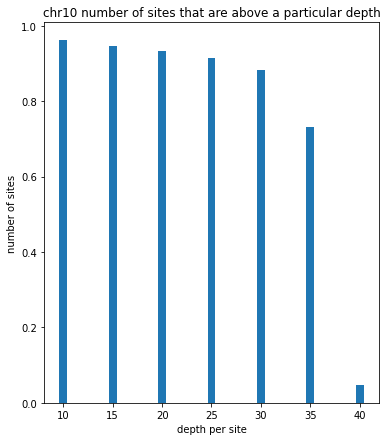

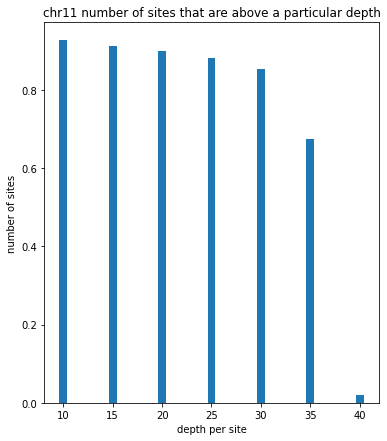

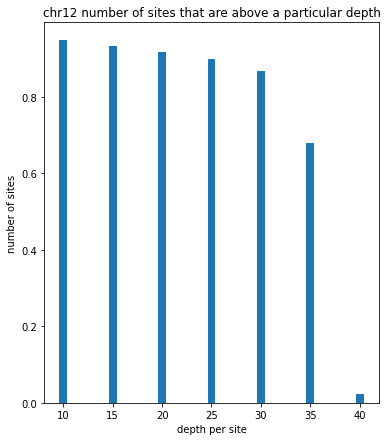

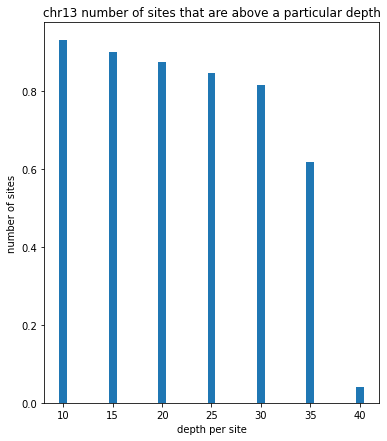

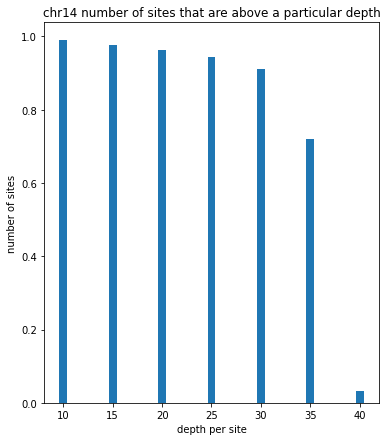

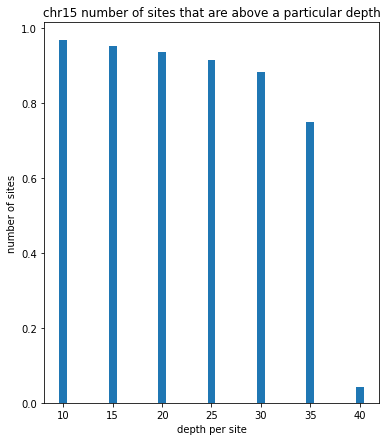

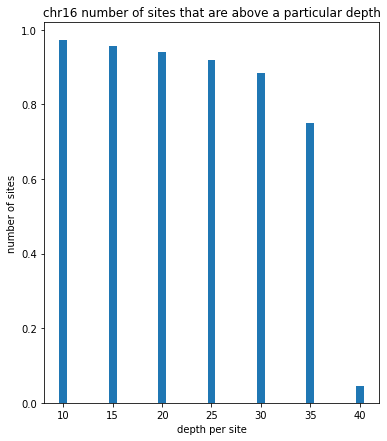

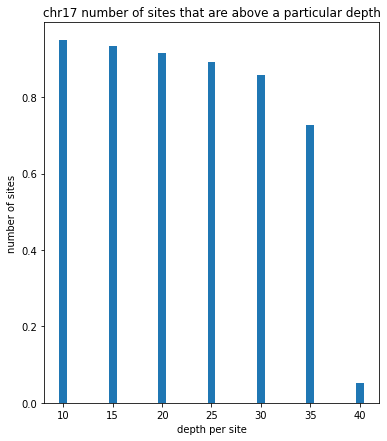

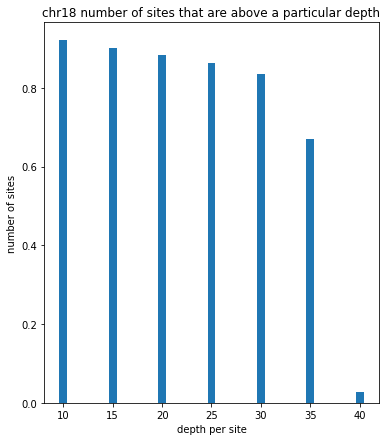

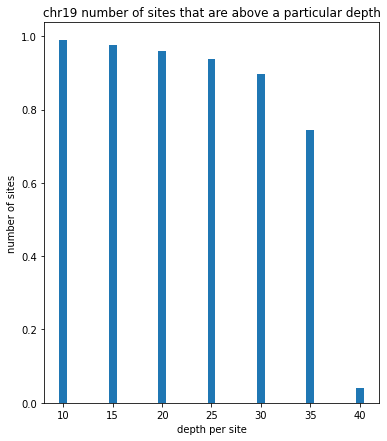

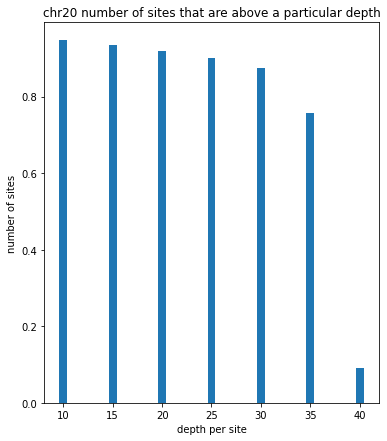

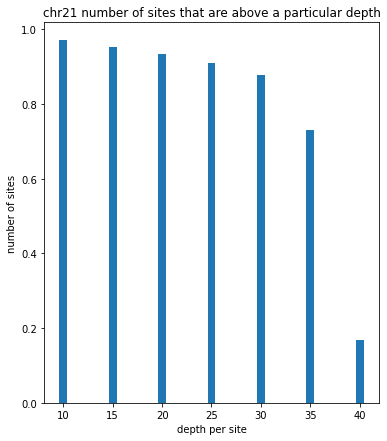

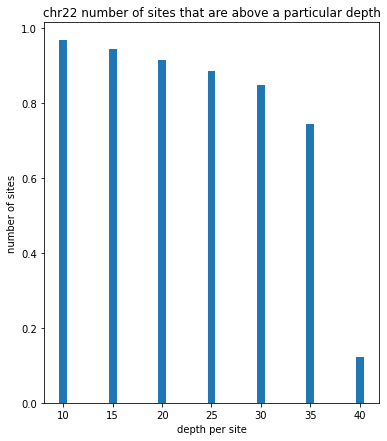

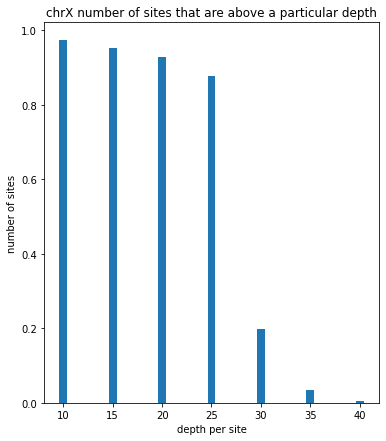

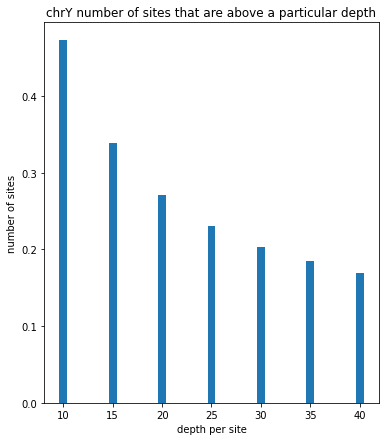

In [41]:
# Plot each chromosome separately
plt.rcParams["figure.figsize"] = (6,7)

for chr in chromosomes:
    depths = sites_per_chr_per_depth[chr]
    plt.bar(depths.keys(), depths.values())
    plt.ylabel('number of sites')
    plt.xlabel('depth per site')
    plt.title('chr' + chr + ' number of sites that are above a particular depth')
    plt.show()

In [43]:
# How many individuals are there in the dataset? How does the mean depth look like per individual?
notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.idepth")

indiv_mean_depth = {}

# Read the idepth file and extract the IDs and mean depths
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_mean_depth[line[0]] = float(line[2])

In [44]:
print('There are ' + str(len(indiv_mean_depth.keys())) + ' individuals in the joint.hg38 TANGL dataset')

There are 1041 individuals in the joint.hg38 TANGL dataset


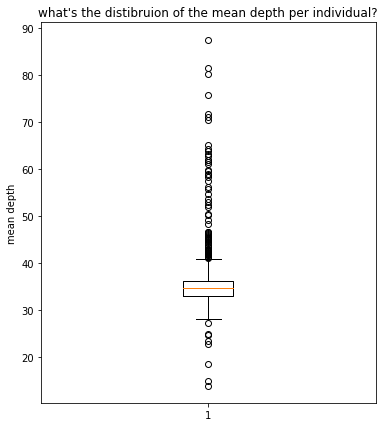

In [47]:
# How does the mean depth look like per individual?

plt.boxplot(indiv_mean_depth.values())
plt.title('what\'s the distibruion of the mean depth per individual?')
plt.ylabel('mean depth')
plt.show()

In [49]:
# How much data is missing per site? 
# Given a site and missingness for all individuals (N = 2082), what's the average for each chr?
# What's the distribution of missingness?

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.lmiss")

miss_per_chr = {}

# Read the idepth file and extract the IDs and mean depths
with open(indiv_depth_file_path, 'r') as f:
    f.readline()   # skip header (CHR, POS, N_DATA, N_GENOTYPE_FILTERED, N_MISS, F_MISS)
    for line in f:
        line = line.split('\t')
        chr, n_miss = line[0][3:], int(line[4])
        if chr not in miss_per_chr.keys():
            print(chr)
            miss_per_chr[chr] = [n_miss]
        else:
            miss_per_chr[chr].append(n_miss)
            

        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


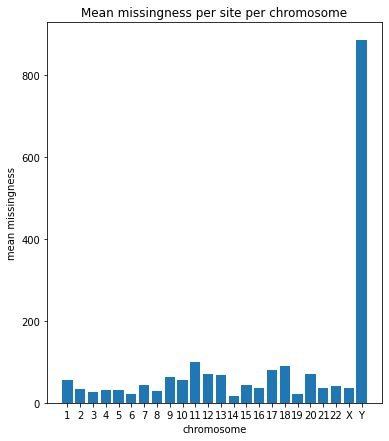

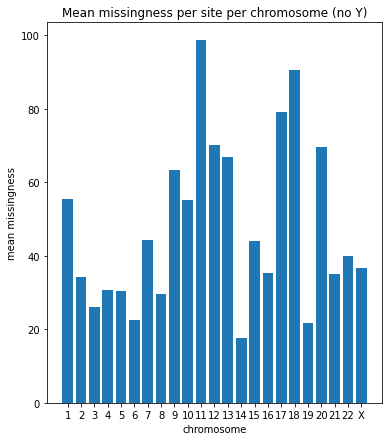

In [62]:
# Plot the mean missingness of each chromosome 

plt.bar(list(miss_per_chr.keys()),[np.mean(miss_per_chr[i]) for i in miss_per_chr.keys()])
plt.title('Mean missingness per site per chromosome')
plt.xlabel('chromosome')
plt.ylabel('mean missingness')
plt.show()

chr_no_y = list(miss_per_chr.keys())[:-1]


plt.bar(chr_no_y,[np.mean(miss_per_chr[i]) for i in chr_no_y])
plt.title('Mean missingness per site per chromosome (no Y)')
plt.xlabel('chromosome')
plt.ylabel('mean missingness')
plt.show()


In [63]:
# There's a lot of variation in the missingness per site. What's the distribution of those numbers per chromosome? 
# How much do they actually vary?

def make_4_cummulant_graphs_missingness(chromosomes):
    """
    Given 4 chromosome labels, create a graph with 4 panels that show
    the distribution of the missingness per chromosome.
    """
    # Show a cumulant graph for the distribution of identity scores
    bins1, fractions1 = make_cummulant(miss_per_chr[chromosomes[0]])
    bins2, fractions2 = make_cummulant(miss_per_chr[chromosomes[1]])
    bins3, fractions3 = make_cummulant(miss_per_chr[chromosomes[2]])
    bins4, fractions4 = make_cummulant(miss_per_chr[chromosomes[3]])

    plt.clf()
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    ax1.plot(bins1, fractions1, label='chr '+chromosomes[0], color='blue')
    ax2.plot(bins2, fractions2, label='chr '+chromosomes[1], color='red')
    ax3.plot(bins3, fractions3, label='chr '+chromosomes[2], color='magenta')
    ax4.plot(bins4, fractions4, label='chr '+chromosomes[3], color='green')

    #plt.plot(bins, fractions)
    ax3.set_xlabel('missingness')
    ax3.set_ylabel('fraction of sites')
    fig.legend()
    fig.suptitle('What is the distribution of missingness for different chromosomes?')
    plt.show()

<Figure size 432x504 with 0 Axes>

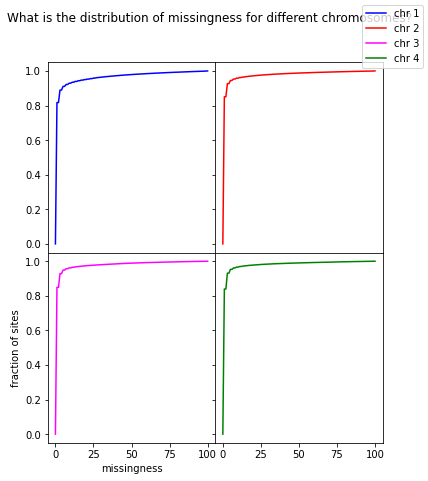

<Figure size 432x504 with 0 Axes>

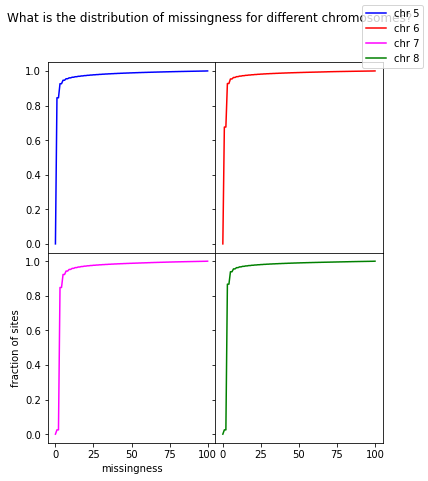

<Figure size 432x504 with 0 Axes>

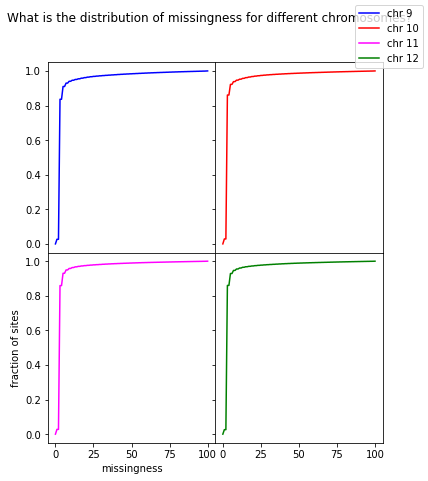

<Figure size 432x504 with 0 Axes>

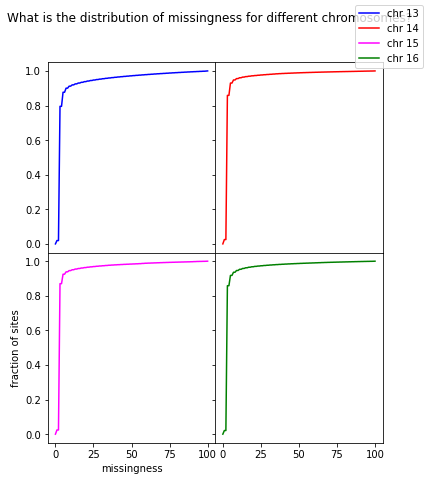

<Figure size 432x504 with 0 Axes>

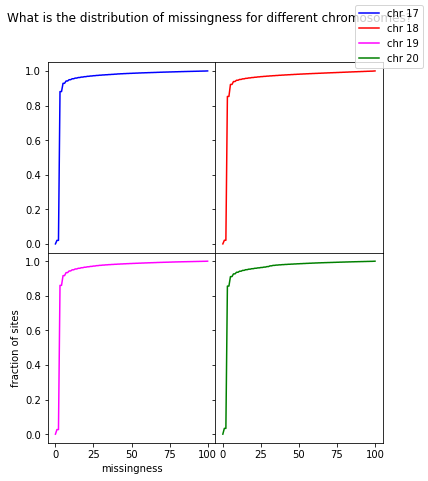

<Figure size 432x504 with 0 Axes>

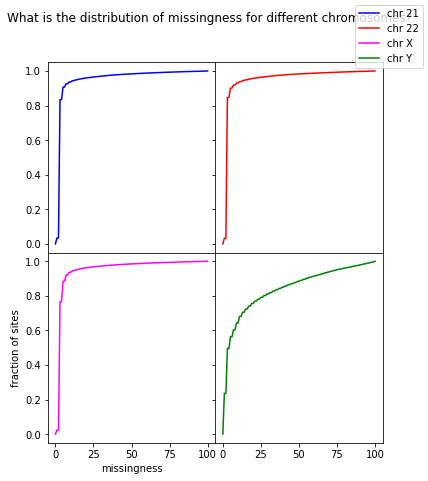

In [65]:
make_4_cummulant_graphs_missingness(['1', '2', '3', '4'])
make_4_cummulant_graphs_missingness(['5', '6', '7', '8'])
make_4_cummulant_graphs_missingness(['9', '10', '11', '12'])
make_4_cummulant_graphs_missingness(['13', '14', '15', '16'])
make_4_cummulant_graphs_missingness(['17', '18', '19', '20'])
make_4_cummulant_graphs_missingness(['21', '22', 'X', 'Y'])

In [90]:
# What about the missingness per individual? How much sites does each individual missing?

notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
indiv_miss_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.imiss")

indiv_missingness = {}
indiv_missingness_f = {}

# Read the imiss file and extract the IDs and N_MISS
with open(indiv_miss_file_path, 'r') as f:
    f.readline()   # skip header
    for line in f:
        line = line.split('\t')
        indiv_missingness[line[0]] = int(line[3])
        indiv_missingness_f[line[0]] = float(line[4])

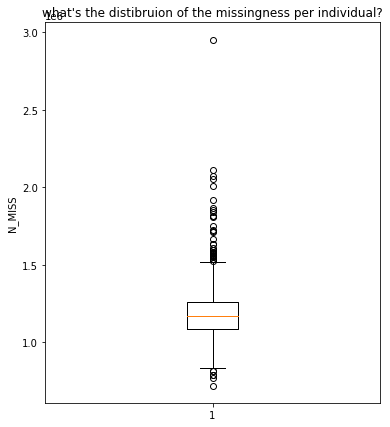

0.588726


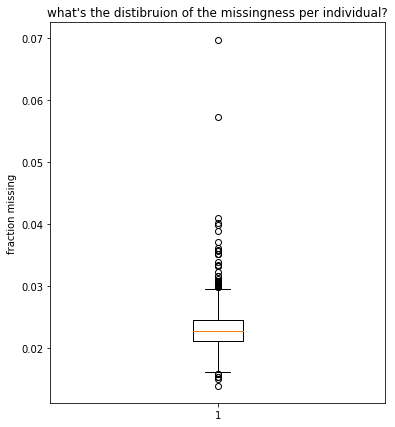

In [93]:
# How does the mean depth look like per individual?

# Get rid of an outlier (~3 MB)
indiv_missingness_vals = np.array(list(indiv_missingness.values()))
indiv_missingness_vals = [i for i in indiv_missingness_vals if i < 3000000]

plt.boxplot(indiv_missingness_vals)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('N_MISS')
plt.show()

# Get rid of the outlier at ~60%
indiv_missingness_fractions = np.array(list(indiv_missingness_f.values()))
indiv_missingness_fractions = [i for i in indiv_missingness_fractions if i < 0.58]

# Same thing but with the fractions instead of full numbers
plt.boxplot(indiv_missingness_fractions)
plt.title('what\'s the distibruion of the missingness per individual?')
plt.ylabel('fraction missing')
plt.show()